# Optimal Panel Forecasting via RL – Summary

We aim to forecast unit A's outcome using selected donor units (e.g., B, C, D). Rather than trying every subset, we use a `reinforcement learning (RL)` policy to choose which donors to include.  

+ Each epoch, the policy proposes a bundle → a model is trained → A's forecast is evaluated.  

+ The policy is **rewarded** based on how accurate the forecast is (using negative MSE).

+ Donor inclusion is sampled using `Gumbel-softmax` to allow exploration.  

+ Over time, the policy learns which donors improve A’s forecast.  

+ We use `entropy` regularization to avoid early overconfidence.  

+ In our synthetic setup, the policy correctly learns to favor useful donors (B, D) and ignore noise (C).  

+ This approach avoids **brute-force** computation and adapts to data-driven donor selection.  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)

years = list(range(1980, 2021))
units = ['A', 'B', 'C', 'D']
data = []

# Create latent signal for A (smooth trend)
signal_A = np.cumsum(np.random.normal(0, 1, len(years)))  # shared latent structure

for year_idx, year in enumerate(years):
    # === Unit A ===
    feature1_A = signal_A[year_idx] + np.random.normal(0, 0.1)  # strong signal
    feature2_A = np.random.normal(0, 1)                         # noise
    if year_idx < len(years) - 1:
        next_signal = signal_A[year_idx + 1]
        gdp_A = 0.5 * next_signal + np.random.normal(0, 0.1)  # target depends on future latent signal
    else:
        gdp_A = np.nan  # last year excluded from prediction
    data.append(['A', year, gdp_A, feature1_A, feature2_A])

    # === Unit B (useful) ===
    feature1_B = signal_A[year_idx] + np.random.normal(0, 0.2)  # correlated with A
    feature2_B = np.random.normal(0, 1)
    gdp_B = 0.5 * signal_A[year_idx] + np.random.normal(0, 0.2)
    data.append(['B', year, gdp_B, feature1_B, feature2_B])

    # === Unit C (useless) ===
    feature1_C = np.random.normal(0, 1)
    feature2_C = np.random.normal(0, 1)
    gdp_C = np.random.normal(1.8, 0.3)
    data.append(['C', year, gdp_C, feature1_C, feature2_C])

    # === Unit D (also useful) ===
    # This donor sees a lagged version of the latent signal — helpful but delayed
    lagged_idx = max(0, year_idx - 1)
    feature1_D = signal_A[lagged_idx] + np.random.normal(0, 0.2)
    feature2_D = np.random.normal(0, 1)
    gdp_D = 0.5 * signal_A[lagged_idx] + np.random.normal(0, 0.2)
    data.append(['D', year, gdp_D, feature1_D, feature2_D])

# Build DataFrame
df = pd.DataFrame(data, columns=['unit', 'year', 'gdp_growth', 'feature1', 'feature2'])

# Drop last year for A (no forward-looking target available)
df = df[~((df['unit'] == 'A') & (df['year'] == 2020))].reset_index(drop=True)

# Sort and normalize
df = df.sort_values(['unit', 'year']).reset_index(drop=True)
scaler = StandardScaler()
df[['feature1', 'feature2']] = scaler.fit_transform(df[['feature1', 'feature2']])

df.head()

,unit,year,gdp_growth,feature1,feature2
0,A,1980,0.149115,0.505939,-0.185500
1,A,1981,0.596197,0.479186,1.109722
2,A,1982,1.364937,0.684202,-0.136208
3,A,1983,0.948751,1.069597,0.048783
4,A,1984,1.127303,1.026181,0.054789


In [2]:
# Pivot to get time-series for each unit's feature1
pivot_feature1 = df.pivot(index='year', columns='unit', values='feature1')

# Compute correlation of A with other units
correlations = pivot_feature1.corr()
similarities = correlations.loc['A', ['B', 'C', 'D']].values
sim_tensor = torch.tensor(similarities, dtype=torch.float32)
similarities

array([0.9989909 , 0.15301309, 0.96613604])

In [3]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=3):
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim)
        self.linear.weight.data = torch.eye(input_dim)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        return self.linear(x)

policy_net = PolicyNet(input_dim=3)
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Dummy similarity vector (replace if you compute real ones)
sim_tensor = torch.tensor([0.9, 0.1, 0.8], dtype=torch.float32)  # B, C, D

# Tracking
inclusion_probs_B = []
inclusion_probs_C = []
inclusion_probs_D = []
avg_mse_per_epoch = []
cumulative_reward_per_epoch = []

forecast_years = list(range(2001, 2020))

for epoch in range(100):
    total_loss = 0
    for t in forecast_years:
        logits = policy_net(sim_tensor.unsqueeze(0)).squeeze()
        probs = torch.sigmoid(logits)

        # Gumbel-softmax sampling
        inclusion_tensor = F.gumbel_softmax(logits, tau=1.0, hard=False)
        included_units = [(unit, inclusion_tensor[i].item() > 0.5) 
                          for i, unit in enumerate(['B', 'C', 'D'])]

        # Build training set
        X_train, y_train = [], []
        for year in range(1980, t - 1):
            xa = df[(df['unit'] == 'A') & (df['year'] == year)][['feature1', 'feature2']].values[0]
            ya = df[(df['unit'] == 'A') & (df['year'] == year)]['gdp_growth'].values[0]
            X_train.append(xa)
            y_train.append(ya)

            for donor, include in included_units:
                if include:
                    xd = df[(df['unit'] == donor) & (df['year'] == year)][['feature1', 'feature2']].values[0]
                    yd = df[(df['unit'] == donor) & (df['year'] == year)]['gdp_growth'].values[0]
                    X_train.append(xd)
                    y_train.append(yd)

        if len(X_train) == 0:
            continue

        X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
        y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)

        rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, min_samples_leaf=10, random_state=42)
        rf_model.fit(X_train_tensor.numpy(), y_train_tensor.numpy().ravel())

        x_eval = df[(df['unit'] == 'A') & (df['year'] == t)][['feature1', 'feature2']].values[0]
        y_true = df[(df['unit'] == 'A') & (df['year'] == t)]['gdp_growth'].values[0]
        x_eval_tensor = torch.tensor(x_eval, dtype=torch.float32).unsqueeze(0)
        y_target = torch.tensor([y_true], dtype=torch.float32).view(1, 1)

        y_pred_val = rf_model.predict(x_eval_tensor.numpy().reshape(1, -1))
        y_pred = torch.tensor([[y_pred_val[0]]], dtype=torch.float32)

        # Reward and loss
        reward = -((y_pred - y_target) ** 2).item()
        policy_loss = -torch.sum(torch.log(inclusion_tensor + 1e-8)) * reward

        # Add entropy regularization
        entropy = -(inclusion_tensor * torch.log(inclusion_tensor + 1e-8)).sum()
        policy_loss -= 0.01 * entropy

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        total_loss += policy_loss.item()

    # Log once per epoch
    with torch.no_grad():
        logits = policy_net(sim_tensor.unsqueeze(0)).squeeze()
        probs = torch.sigmoid(logits)
        inclusion_probs_B.append(probs[0].item())
        inclusion_probs_C.append(probs[1].item())
        inclusion_probs_D.append(probs[2].item())

    avg_mse = total_loss / len(forecast_years)
    avg_mse_per_epoch.append(avg_mse)
    cumulative_reward_per_epoch.append(-total_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Policy Loss: {total_loss:.4f}, Entropy: {entropy.item():.4f}")

Epoch 0, Policy Loss: -228.6289, Entropy: 0.9095
Epoch 10, Policy Loss: -262.2242, Entropy: 0.7705
Epoch 20, Policy Loss: -196.5869, Entropy: 0.4390
Epoch 30, Policy Loss: -169.5369, Entropy: 0.9237
Epoch 40, Policy Loss: -201.2550, Entropy: 0.9516
Epoch 50, Policy Loss: -198.0751, Entropy: 0.9602
Epoch 60, Policy Loss: -188.8232, Entropy: 1.0962
Epoch 70, Policy Loss: -193.5449, Entropy: 0.7912
Epoch 80, Policy Loss: -180.6099, Entropy: 0.6664
Epoch 90, Policy Loss: -151.8066, Entropy: 0.7597


In [4]:
with torch.no_grad():
    logits = policy_net(sim_tensor.unsqueeze(0)).squeeze()
    probs = torch.sigmoid(logits)
    print(f"Epoch {epoch}, B: {probs[0]:.3f}, C: {probs[1]:.3f}, D: {probs[2]:.3f}")

Epoch 99, B: 0.913, C: 0.303, D: 0.589


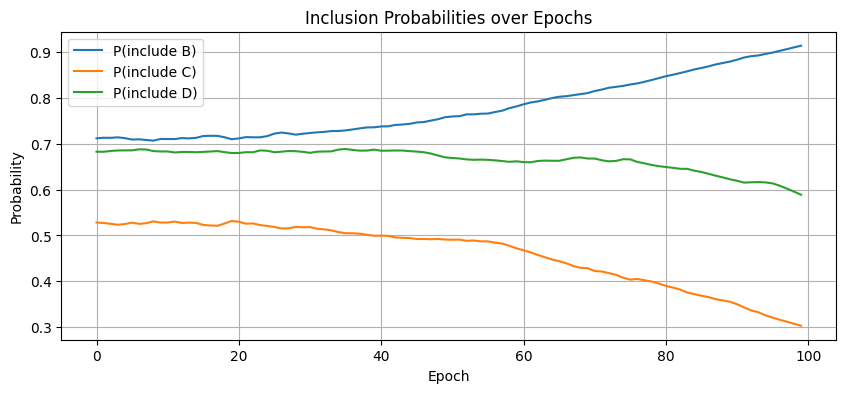

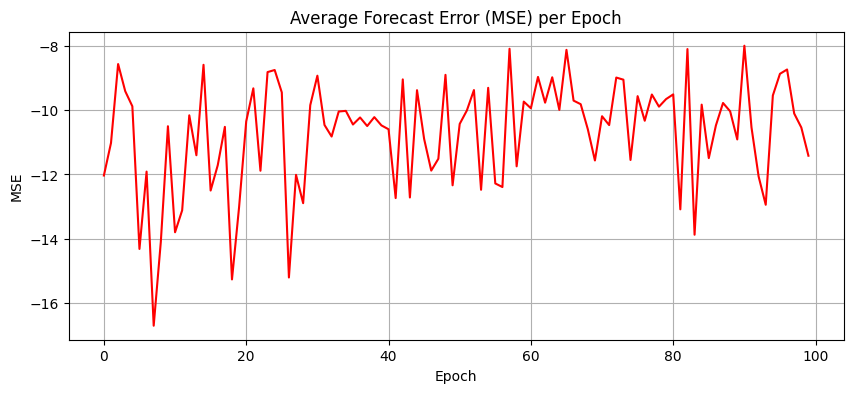

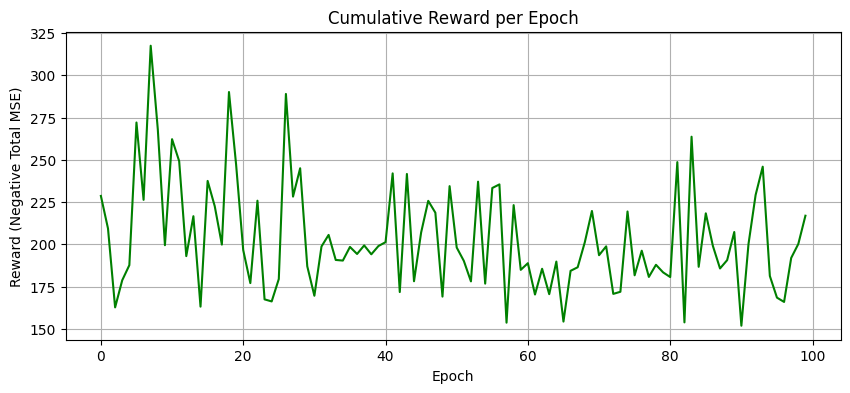

In [5]:
import matplotlib.pyplot as plt

epochs = list(range(len(inclusion_probs_B)))

# Plot 1: Inclusion probabilities
plt.figure(figsize=(10, 4))
plt.plot(epochs, inclusion_probs_B, label='P(include B)')
plt.plot(epochs, inclusion_probs_C, label='P(include C)')
plt.plot(epochs, inclusion_probs_D, label='P(include D)')
plt.title('Inclusion Probabilities over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Forecast Error (MSE)
plt.figure(figsize=(10, 4))
plt.plot(epochs, avg_mse_per_epoch, color='red')
plt.title('Average Forecast Error (MSE) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Reward
plt.figure(figsize=(10, 4))
plt.plot(epochs, cumulative_reward_per_epoch, color='green')
plt.title('Cumulative Reward per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Reward (Negative Total MSE)')
plt.grid(True)
plt.show()